In [15]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from preprocessing import load_unsw_data, preprocess_data
from selection import apply_pca, unsupervised_feature_selection

In [16]:
def evaluate_anomaly_model(model, X_test, y_test, model_name):

    preds = model.predict(X_test)
    preds = np.where(preds == -1, 1, 0)  # -1 → anomaly → 1, 1 → normal → 0

    auc = roc_auc_score(y_test, preds)
    print(f"[{model_name}] ROC-AUC: {auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix — {model_name}")
    plt.savefig(f"../outputs/figures/{model_name}_confusion_matrix.png", dpi=300)
    plt.close()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, preds)
    plt.title(f"ROC Curve — {model_name}")
    plt.savefig(f"../outputs/figures/{model_name}_roc_curve.png", dpi=300)
    plt.close()

    # Anomaly Score Distribution (if supported)
    if hasattr(model, "decision_function"):
        scores = -model.decision_function(X_test)
        plt.figure(figsize=(8, 5))
        plt.hist(scores[y_test == 0], bins=50, alpha=0.7, label='Normal')
        plt.hist(scores[y_test == 1], bins=50, alpha=0.7, label='Attack')
        plt.title(f"Anomaly Score Distribution — {model_name}")
        plt.xlabel("Anomaly Score")
        plt.ylabel("Frequency")
        plt.legend()
        plt.savefig(f"../outputs/figures/{model_name}_score_distribution.png", dpi=300)
        plt.close()

    return auc


In [17]:
print("[1] Loading UNSW-NB15 dataset...")
df = load_unsw_data("../data/")
X_train, X_test, y_train, y_test = preprocess_data(
        df, 
        model_type='unsupervised',
        apply_smote=False
    )
print(f"Dataset loaded. Train: {X_train.shape}, Test: {X_test.shape}")

[1] Loading UNSW-NB15 dataset...
Loaded UNSW-NB15 dataset: 2540047 rows, 49 columns
Dropped 'attack_cat' column (prevented leakage).
Dropped 7 highly correlated feature(s): ['sloss', 'dloss', 'Dpkts', 'dwin', 'Ltime', 'synack', 'ackdat']
Unsupervised model detected - SMOTE not applied
Data split complete → Train: (1441590, 40), Test: (617825, 40)
Label distribution (train):
Label
0    0.951616
1    0.048384
Name: proportion, dtype: float64
Dataset loaded. Train: (1441590, 40), Test: (617825, 40)


In [18]:
print("\n[2] Performing Feature Selection and PCA...")

#feature selection using Variance Threshold
X_train_fs = unsupervised_feature_selection(X_train)
X_test_fs = X_test[X_train_fs.columns]

# Apply PCA for anomaly modeling
X_train_pca, X_test_pca, _ = apply_pca(X_train_fs, X_test_fs, n_components=25)

print(f"Final Feature Shape: {X_train_pca.shape}")


[2] Performing Feature Selection and PCA...
Retained 40 high-variance features out of 40
Applied PCA → 25 components explain 92.87% variance.
Final Feature Shape: (1441590, 25)


In [ ]:
print("[3] Loading models...")
isolation_forest = joblib.load("../outputs/models/isolation_forest.pkl")
one_class_svm = joblib.load("../outputs/models/one_class_svm.pkl")

[3]Loading models...


In [21]:
print("[4] Evaluating models..")
iso_auc = evaluate_anomaly_model(isolation_forest, X_test_pca, y_test, "IsolationForest")
ocsvm_auc = evaluate_anomaly_model(one_class_svm, X_test_pca, y_test, "OneClassSVM")

[4] Evaluating models..
[IsolationForest] ROC-AUC: 0.585
[OneClassSVM] ROC-AUC: 0.858


In [23]:
print(f"\nEvaluation complete.\nIsolation Forest ROC-AUC: {iso_auc:.3f}\nOne-Class SVM ROC-AUC: {ocsvm_auc:.3f}")


Evaluation complete.
Isolation Forest ROC-AUC: 0.585
One-Class SVM ROC-AUC: 0.858


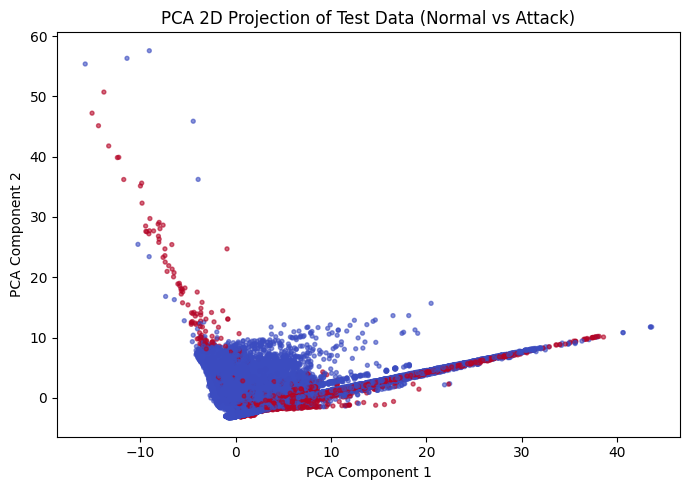

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="coolwarm", s=8, alpha=0.6)
plt.title("PCA 2D Projection of Test Data (Normal vs Attack)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.savefig("../outputs/figures/pca_visualization.png")
plt.show()